In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from mssm.models import *
from mssm.src.python.compare import GLRT_CDL
np.set_printoptions(suppress=True)

nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

## Data structure

In [2]:
# Import some simulated data
dat = pd.read_csv("./data/GAMM/sim_dat.csv")

# mssm requires that the data-type for variables used as factors is 'O'=object
dat = dat.astype({'series': 'O',
                  'cond':'O',
                  'sub':'O',
                  'series':'O'})

Some remarks about the desired layout of the data to be usable with the GAMM class:
- The dependent variable can contain NAs, which will be taken care of. No NAs should be present in any of the predictor columns!
- The data-type (dtype) for numeric columns should be float or int. Categorical predictors need to have the object datatype (see code above).
- No specific row/column sorting is required.

In [3]:
# Take a look at the data:
dat.head()

,y,time,series,cond,sub,x
0,7.005558,0,0,a,0,9.817736
1,11.122316,20,0,a,0,10.262371
2,4.766720,40,0,a,0,10.445887
3,2.952046,60,0,a,0,8.481554
4,7.463034,80,0,a,0,10.180660


## Building GAMMs

### Getting started!

We can build a broad variety of GAMMs as they are also supported in mgcv (Wood, 2017). Smooths that are available in mgcv and are also supported here include regular univariate smooths, binary smooth terms, Tensor smooth interactions, by-factor smooths, and random non-linear smooths. mssm also supports random effects (random intercepts, random slopes, and as mentioned random smooths).

A B-spline basis is used by mssm and penalties are either difference (Eilers & Marx, 2010) or identity penalties (Null-space penalties, Marra & Wood (2012) are also supported). Currently, Binomial models (N >= 1) and Gaussian models are supported!

mssm automatically figures out the right amount of penalization for all terms using a combination of the approaches discussed by Wood & Fasiolo (2017) in "A generalized Fellner-Schall method for smoothing parameter optimization with application to Tweedie location, scale and shape models." and by Wood, Shaddick, & Augustin, (2017). "Generalized Additive Models for Gigadata: Modeling the U.K. Black Smoke Network Daily Data."

mssm uses sparse matrices and is thus particularly suited to handle models of many random effects!

In [4]:
# Build a simple GAMM
# y = a + f(time) + e with e ~ N(0,sigma)
formula = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"])], # The f(time) term, by default parameterized with 9 basis functions (after absorbing one for identifiability)
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:1106: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [5]:
# Initialize the GAMM as a Gaussian one, i.e., Pupil ~ N(a + f(time),sigma)
model = GAMM(formula,Gaussian())

In [6]:
# Some info about the size of this model:
print(f"Model will estimate {model.formula.get_n_coef()} coefficients from {len(model.formula.get_depvar()[model.formula.get_notNA()])} datapoints!")

Model will estimate 10 coefficients from 29217 datapoints!


In [7]:
# Fit the model
model.fit()

NAs were excluded for fitting.


Converged!:   0%|          | 0/50 [00:00<?, ?it/s]                


In [8]:
# We can print a summary of the smooth terms included in the model
# and the estimated degrees of freedom corresponding to each:
model.print_smooth_terms() # The model has used approximately 8.72 basis functions (of the 9 it could use).

f(['time']; edf: 8.723


In [9]:
# To get the total degrees of freedom used by the model we can access the ``edf`` argument:
round(model.edf,ndigits=3)

9.723

In [10]:
# Get predictions and parameter estimates
coef, sigma = model.get_pars() # Coef = weights for basis functions, sigma = **variance** of residuals!
pred = model.pred # The model prediction for the entire data, here: a + f(Time)!
res = model.res # The residuals
y = model.formula.y_flat[model.formula.NOT_NA_flat] # The dependent variable after NAs were removed

In [11]:
round(model.formula.penalties[0].lam,ndigits=5)

0.0089

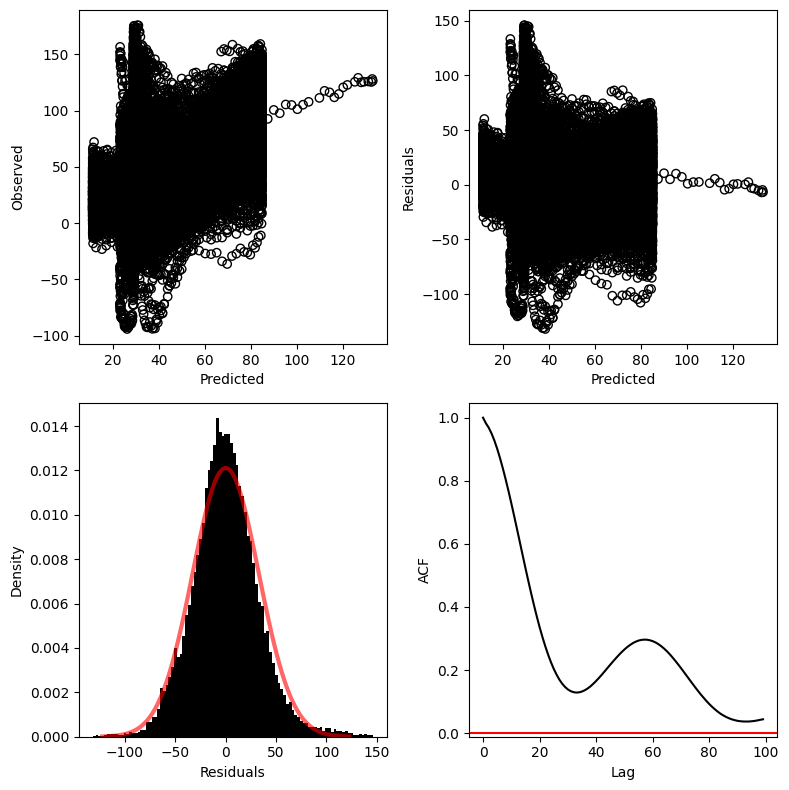

In [12]:
# Check model performance
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(pred,y,color="black",facecolor='none')
plt.xlabel("Predicted")
plt.ylabel("Observed")


plt.subplot(2,2,2)
plt.scatter(pred,res,color="black",facecolor='none')
plt.xlabel("Predicted")
plt.ylabel("Residuals")


plt.subplot(2,2,3)
plt.hist(res,bins=100,density=True,color="black")
x = np.linspace(scp.stats.norm.ppf(0.0001,scale=math.sqrt(sigma)),
                scp.stats.norm.ppf(0.9999,scale=math.sqrt(sigma)), 100)

plt.plot(x, scp.stats.norm.pdf(x,scale=math.sqrt(sigma)),
        'r-', lw=3, alpha=0.6)
plt.xlabel("Residuals")
plt.ylabel("Density")

# Auto-correlation check
lag = 100
cc = np.vstack([res[:-lag,0],*[res[l:-(lag-l),0] for l in range(1,lag)]]).T
acf = [np.corrcoef(cc[:,0],cc[:,l])[0,1] for l in range(lag)]

plt.subplot(2,2,4)
plt.plot(range(lag),acf,color="black")
plt.axhline(0,color="red")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

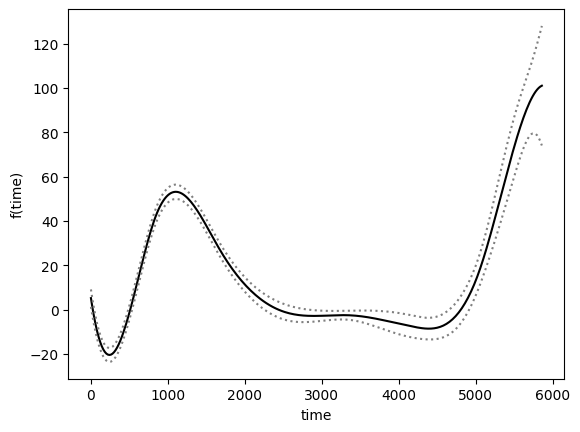

In [13]:
# Partial prediction for a single smooth
time_pred = [t for t in range(0,max(dat["time"]),20)]
new_dat = pd.DataFrame({"time":time_pred})

# Make partial prediction using just terms[1] - the smooth of time or f(time)!
pred,pred_mat,boundary = model.predict([1],new_dat,ci=True,alpha=0.05)

plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred + boundary,color='grey', linestyle='dotted')
plt.plot(time_pred,pred - boundary,color='grey', linestyle='dotted')
plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

### A by-condition GAM

To get a by-factor model (s(Time,by=cond) in mgcv) mssm also provides a by keyword!

In [14]:
# y = a + b1*c1 + f0(time) + f1(time) + e
# with e ~ N(0,sigma) and c1 == 1 if cond == "b" else 0
# and f0() and f1() representing the smooths over time for
# the first (a) and second (b) level of cond respectively.
formula2 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # One coefficient per dummy-predictor necessary for factor cond - here b1
                               f(["time"],by="cond")], # One f(time) term for every level of cond
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:1106: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [15]:
# Fit the model
model2 = GAMM(formula2,Gaussian())
model2.fit()

NAs were excluded for fitting.


Converged!:   0%|          | 0/50 [00:00<?, ?it/s]                


In [16]:
# Again, we print a summary of the edf. per term in the model.
# Note: separate smooths were estimated for each level of "cond" so two edf values are printed.
model2.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.881
f(['time'],by=cond): b; edf: 8.714


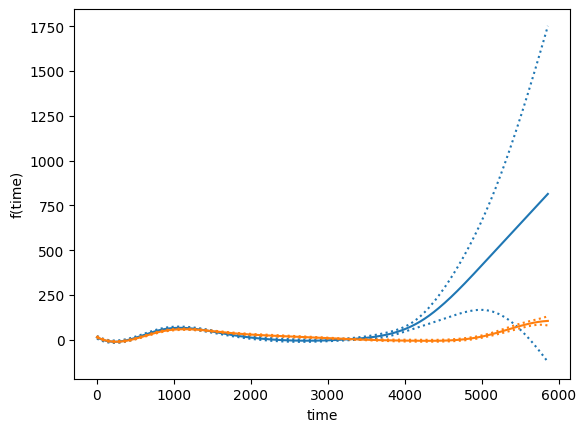

In [17]:
# Partial prediction (using only the f(time)) for all conditions
# Basically what plot(model) does in R in case model was obtained from mgcv

for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred})
    
    # Make prediction using only the correct f(time) for every condition
    pred,_,b = model2.predict([2],new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

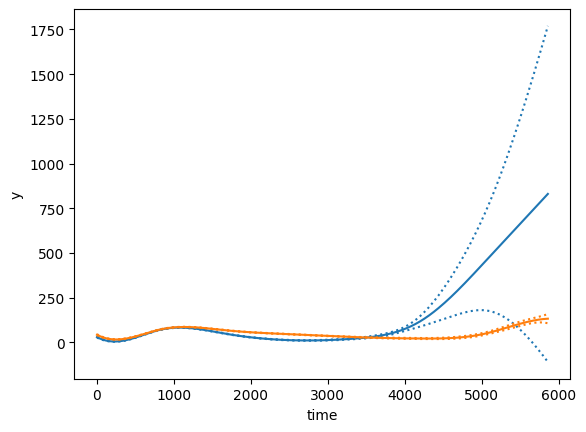

In [18]:
# Fixed prediction (using not only the f(time) but also a and b1!) for all conditions
# Basically the model prediction per condition.
# Note how the y-axis changes but not the shape of the smooths!

for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred})
    
    # Make prediction using all terms in the model - set the first argument to None
    pred,_,b = model2.predict(None,new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("y")
plt.show()

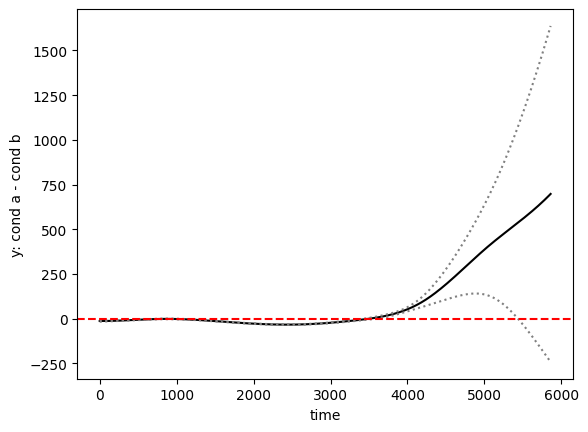

In [19]:
# Difference predictions between two conditions!
# Allows us to plot the predicted difference over time between conditions a and b.
# This is basically the difference between the two curves shown in the last plot -
# so the offset differences induced by a and b1 are taken into account!!
time_pred = [t for t in range(0,max(dat["time"]),20)]
new_dat1 = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                         "time":time_pred})

new_dat2 = pd.DataFrame({"cond":["b" for _ in range(len(time_pred))],
                         "time":time_pred})

diff,b = model2.predict_diff(new_dat1,new_dat2,None)

plt.plot(time_pred,diff,color='black')
plt.plot(time_pred,diff + b,color='grey', linestyle='dotted')
plt.plot(time_pred,diff - b,color='grey', linestyle='dotted')
plt.axhline(0,color="red",linestyle="dashed")
plt.xlabel("time")
plt.ylabel("y: cond a - cond b")
plt.show()

### A binary smooth model
If the difference between conditions is of interest it might be more desirable to fit a difference curve for specific levels of the factor of interest.
Such a model is set up below!

In [20]:
formula3 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"]), # One f(time) term - will correspond to the baseline level for condition: here let's choose b
                               f(["time"],binary=["cond","a"])], # Another f(time), this one models the difference over time from the other f(time) term for cond=a!
                        data=dat)

In [21]:
# Fit the model
model3 = GAMM(formula3,Gaussian())
model3.fit()
model3.print_smooth_terms()

NAs were excluded for fitting.


Converged!:   0%|          | 0/50 [00:00<?, ?it/s]                

f(['time']; edf: 8.72
f(['time'],by=a); edf: 6.693


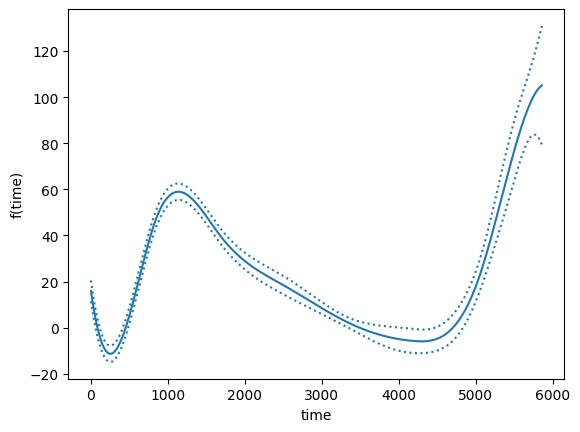

In [22]:
# Let's look at just the f(time) for level b - this one looks just like before!
time_pred = [t for t in range(0,max(dat["time"]),20)]

new_dat = pd.DataFrame({"cond":["b" for _ in range(len(time_pred))],
                        "time":time_pred})

# Make prediction using just the first f(time) term!
pred,_,b = model3.predict([1],new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color=colors[0])
plt.plot(time_pred,pred+b,color=colors[0], linestyle='dotted')
plt.plot(time_pred,pred-b,color=colors[0], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

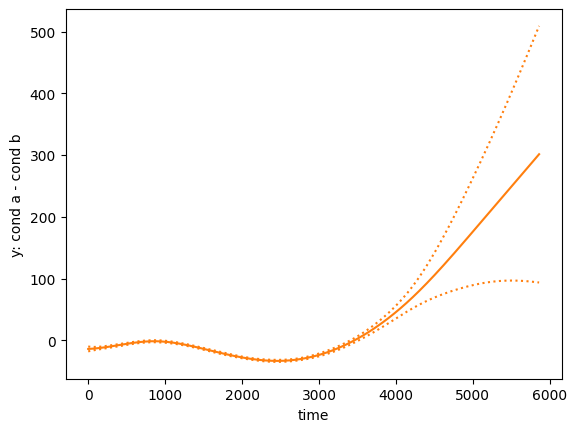

In [23]:
# However, just the prediction from the second f(time) does look very different
# now! In fact it represents the difference between the two conditions again!
time_pred = [t for t in range(0,max(dat["time"]),20)]

new_dat = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                        "time":time_pred})

# Make prediction using just the first f(time) term!
pred,_,b = model3.predict([2],new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color=colors[1])
plt.plot(time_pred,pred+b,color=colors[1], linestyle='dotted')
plt.plot(time_pred,pred-b,color=colors[1], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("y: cond a - cond b")
plt.show()

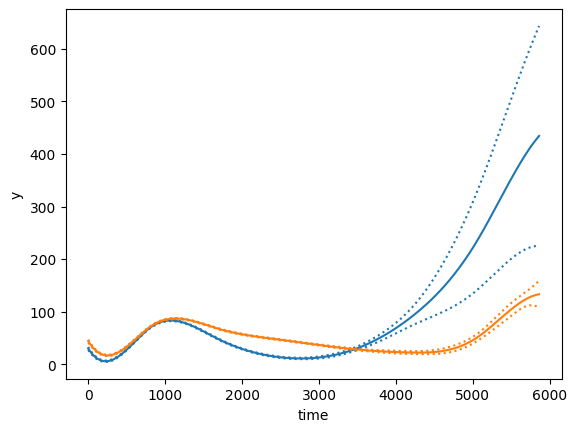

In [24]:
# If we use all terms we can still predict how y changes over time for both conditions:
for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred})
    
    # Make prediction using all terms in the model - set the first argument to None
    pred,_,b = model3.predict(None,new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("time")
plt.ylabel("y")
plt.show()

### Tensor smooth interactions

Non-linear interactions between continuous variables are supported via tensor smooth interactions (see Wood, 2017). Both the behavior achieved by the ti() and te() terms in mgcv is supported. Let's start with considering the te() term behavior!

In [25]:
formula4 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time","x"],by="cond",te=True)], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        data=dat)

In [26]:
# Fit the model
model4 = GAMM(formula4,Gaussian())
model4.fit()

# We end up with two smooth terms - one surface for every level of cond.
model4.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  78%|███████▊  | 39/50 [00:01<00:00, 29.23it/s]                

f(['time', 'x'],by=cond): a; edf: 12.69
f(['time', 'x'],by=cond): b; edf: 19.142


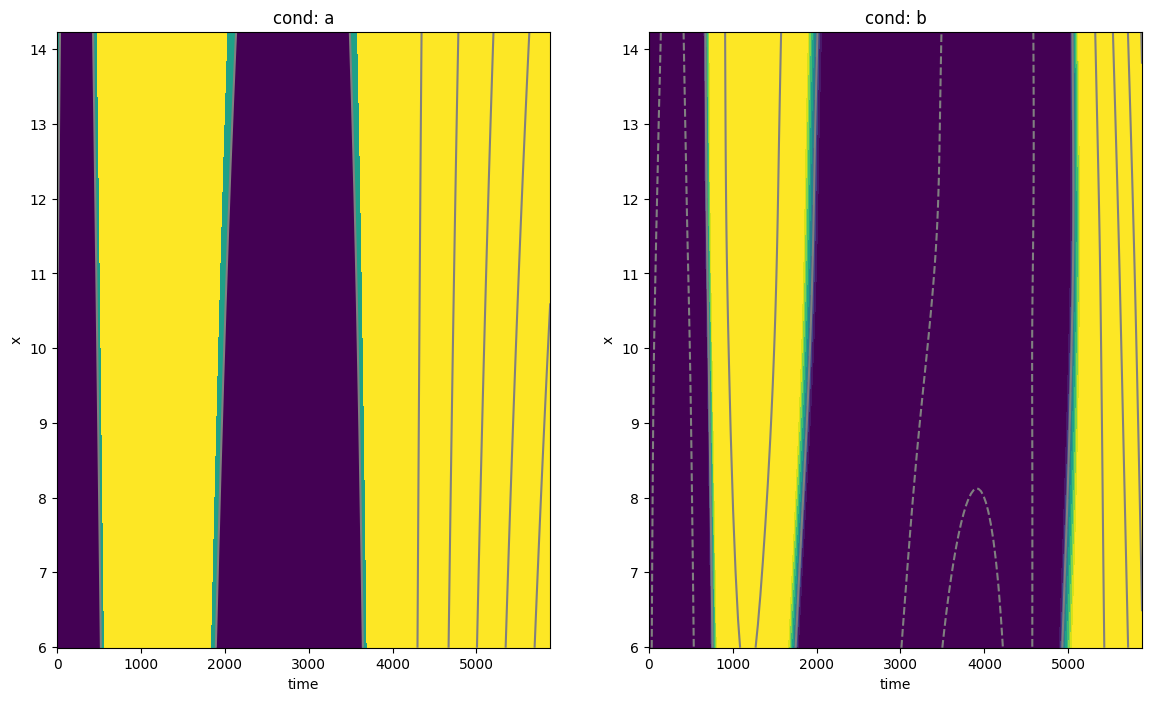

In [27]:
# Visualizing the partial interaction
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})

    TP_pred,_,_ = model4.predict([2],new_dat)

    ax = fig.add_subplot(1,2,ci+1) #projection='3d'

    #ax.view_init(elev=25, azim=-10)
    #ax.scatter(freq_pred, time_pred, TP_pred, c = TP_pred, s = 1)

    ff = ax.contourf(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,colors="grey")
    ax.set_ylim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("x")
    ax.set_xlabel("time")

The ti() term in mgcv enables decomposing the 3-way interaction into separate interaction (including lower order interactions) and main effects! In ``mssm`` this is achieved by omitting the ``te=True`` argument (the default). In that case, separate smooth terms have to be included for the lower order interactions. The model below exemplifies this. Note: an extra argument has been added to the smooth terms `constraint=ConstType.QR=True`. The reason for this is explained in `Constraint.__doc__` (see below). 

In [28]:
# To access doc-strings, simply print function.__doc__
# from mssm.src.python.constraints import Constraint
# print(Constraint.__doc__)

In [29]:
formula5 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time"],by="cond",constraint=ConstType.QR), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",constraint=ConstType.QR), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",constraint=ConstType.QR)], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        data=dat)

In [30]:
# Fit the model
model5 = GAMM(formula5,Gaussian())
model5.fit()

# We end up with a total of 6 smooth terms in this model!
model5.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  80%|████████  | 40/50 [00:09<00:02,  4.13it/s]                

f(['time'],by=cond): a; edf: 6.88
f(['time'],by=cond): b; edf: 8.715
f(['x'],by=cond): a; edf: 1.012
f(['x'],by=cond): b; edf: 1.0
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 4.395


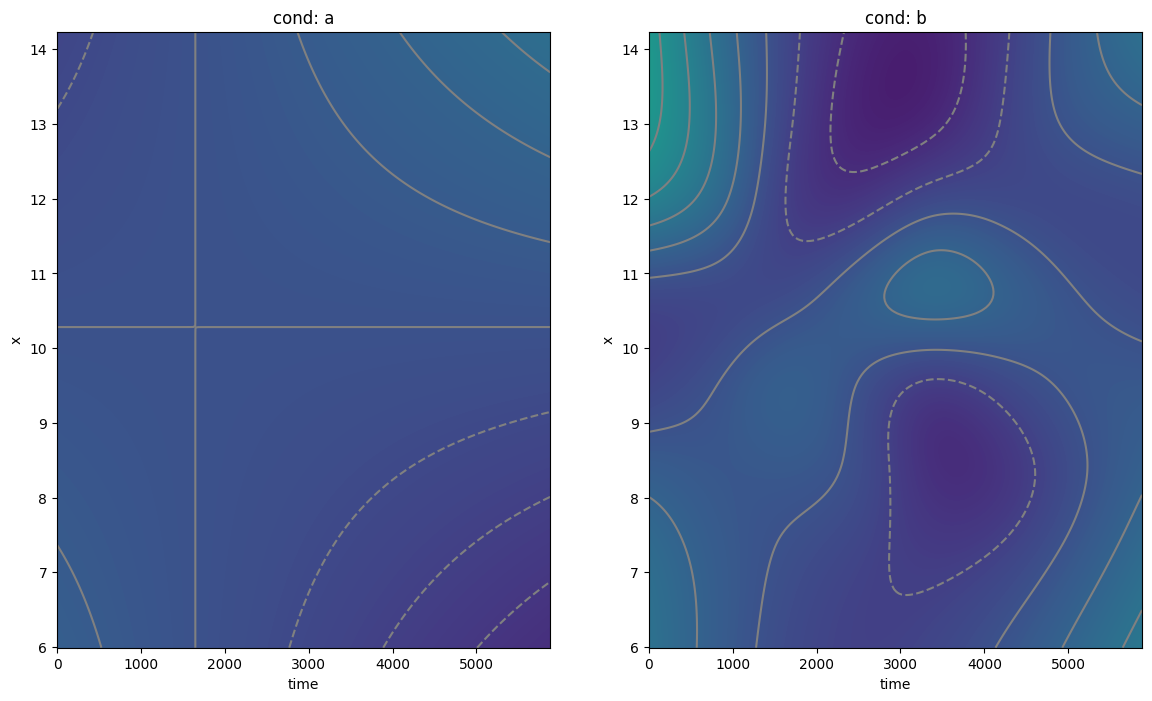

In [31]:
# Visualizing the partial interaction. Now the surface really covers only the three-way interaction estimate. Hence, it looks very different from the previous plots.
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})

    TP_pred,_,_ = model5.predict([4],new_dat)

    ax = fig.add_subplot(1,2,ci+1) #projection='3d'

    #ax.view_init(elev=25, azim=-10)
    #ax.scatter(freq_pred, time_pred, TP_pred, c = TP_pred, s = 1)

    ff = ax.contourf(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,colors="grey")
    ax.set_ylim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("x")
    ax.set_xlabel("time")

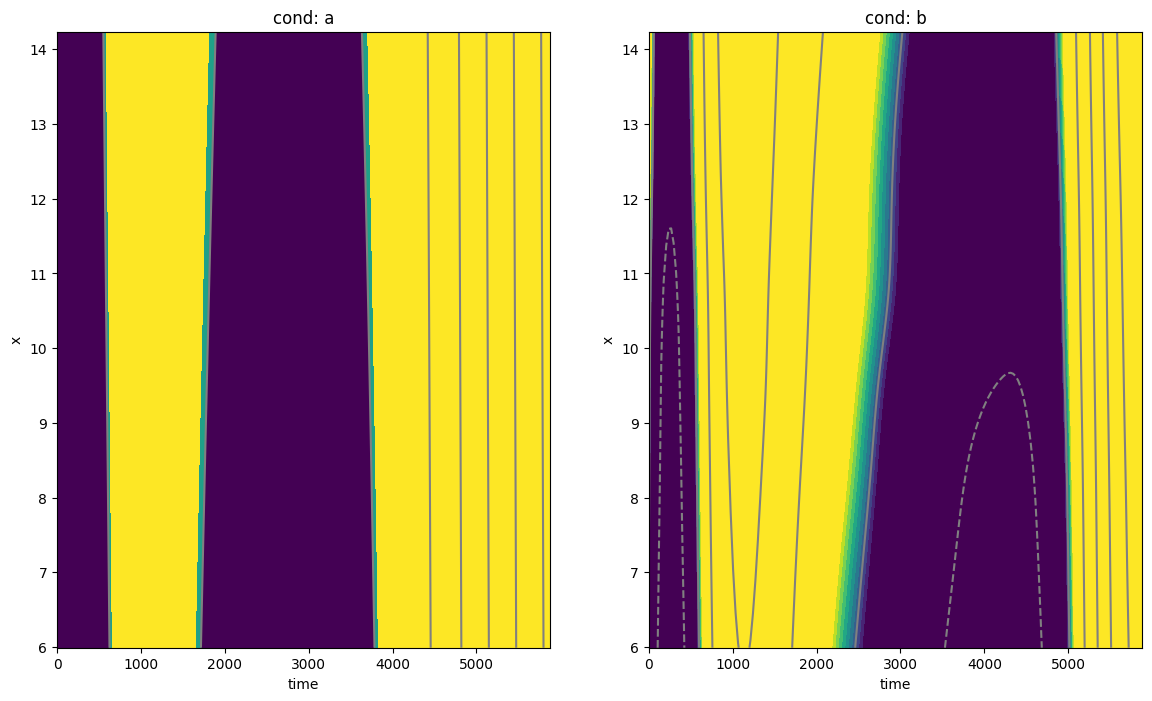

In [32]:
# Visualizing the three-way interaction + the two-way interactions approximates the surfaces estimated by model4, which did not attempt to decompose these.
# In this case, the plots are quite similar. This is not guaranteed, and in practice models set up like model5 will tend to produce more flexible solutions - because they have
# a larger solution space, in which they might find evidence for a more complex solution.
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})

    TP_pred,_,_ = model5.predict([1,2,3,4],new_dat)

    ax = fig.add_subplot(1,2,ci+1)

    ff = ax.contourf(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,colors="grey")
    ax.set_ylim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("x")
    ax.set_xlabel("time")

### Binary tensor smooth interactions
The binary smooth approach generalizes beyond the univariate case to the tensor smooth interaction case. Essentially, we then fit a smooth surface for the reference level and difference surfaces for the remaining levels of a factor. Such a model is set up below.

In [33]:
formula6 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time","x"],te=True), # one smooth surface over time and x - f(time,x) - for the reference level = cond == b
                               f(["time","x"],te=True,binary=["cond","a"])], # another smooth surface over time and x - f(time,x) - representing the difference from the other surface when cond==a
                        data=dat)

In [34]:
# Fit the model
model6 = GAMM(formula6,Gaussian())
model6.fit()

# We again end up with two smooth terms in the model.
model6.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  78%|███████▊  | 39/50 [00:01<00:00, 22.26it/s]                

f(['time', 'x']; edf: 16.636
f(['time', 'x'],by=a); edf: 12.205


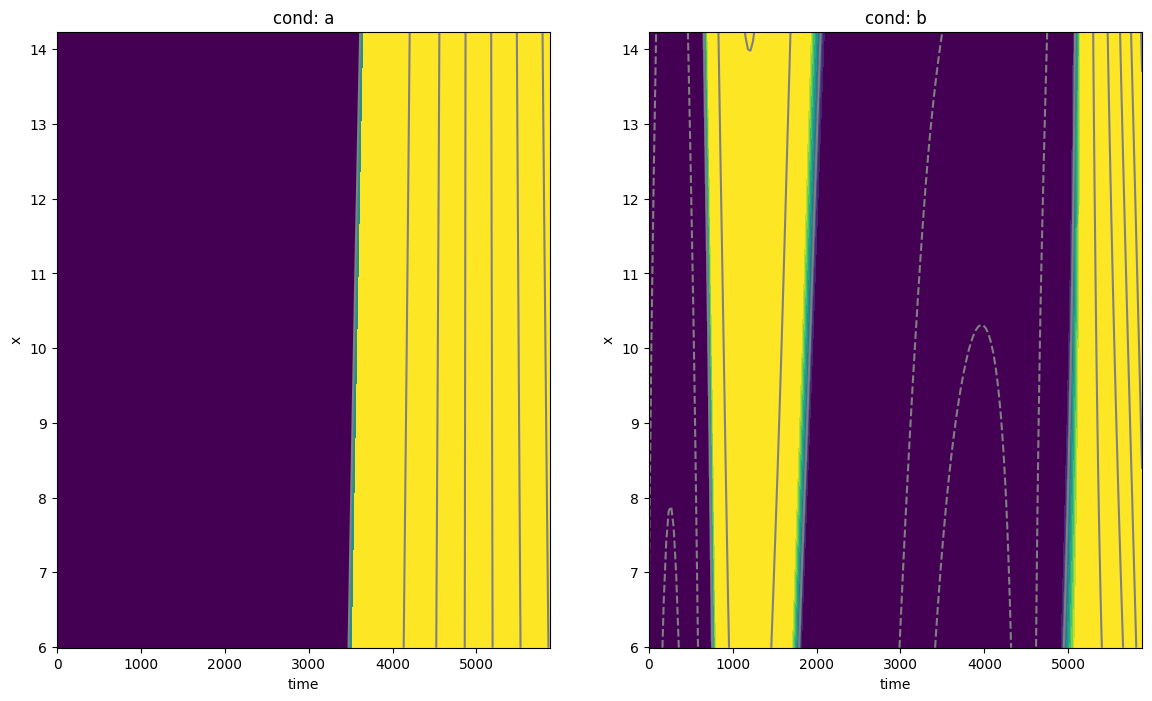

In [35]:
# Visualizing the two surfaces reveals the same picture visibile for the univariate case: the right surface largely matches the surface estimated by
# model 4! The left surface is now the difference surface estimated for condition b!
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})

    use = 1
    if c == "a":
        # Show difference smooth for cond=="a"
        use = 2

    TP_pred,_,_ = model6.predict([use],new_dat)

    ax = fig.add_subplot(1,2,ci+1)

    ff = ax.contourf(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,colors="grey")
    ax.set_ylim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("x")
    ax.set_xlabel("time")

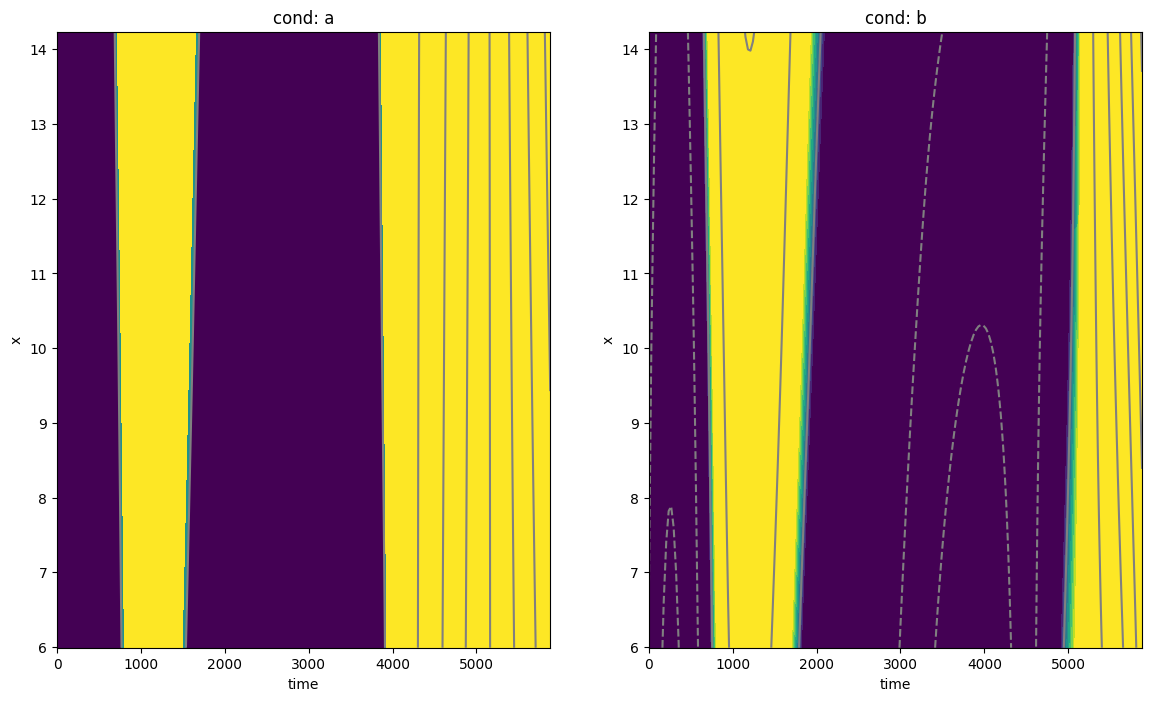

In [36]:
# Hence, to recover the actual surfaces for both conditions we need to add them together when cond == "a"
fig = plt.figure(figsize=(14,8))

for ci,c in enumerate(["a","b"]):
    time_pred = []
    x_pred = []

    xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),200)]
    tr = np.linspace(0,max(dat["time"]),len(xr))

    for t in tr:
        for x in xr:
            time_pred.append(t)
            x_pred.append(x)

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})

    # We can simply include both terms for both conditions since
    # term 2 will be all zeros when cond == b
    TP_pred,_,_ = model6.predict([1,2],new_dat)

    ax = fig.add_subplot(1,2,ci+1)

    ff = ax.contourf(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,levels=len(xr),vmin=-2,vmax=6)
    ll = ax.contour(tr,xr,TP_pred.reshape(len(xr),len(xr)).T,colors="grey")
    ax.set_ylim((min(dat["x"]),max(dat["x"])))
    ax.set_title(f"cond: {c}")
    ax.set_ylabel("x")
    ax.set_xlabel("time")

### Random effects
We can also include random intercepts, random slopes, and non-linear random effects - here we show an example of the latter.

In [37]:
formula7 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",constraint=ConstType.QR), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",constraint=ConstType.QR), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",constraint=ConstType.QR), # three-way interaction
                               fs(["time"],rf="sub")], # Random non-linear effect of time - one smooth per level of factor sub
                        data=dat)

In [38]:
# Fit the model
model7 = GAMM(formula7,Gaussian())
model7.fit()
model7.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  18%|█▊        | 9/50 [00:03<00:14,  2.86it/s]                

f(['time'],by=cond): a; edf: 6.892
f(['time'],by=cond): b; edf: 8.635
f(['x'],by=cond): a; edf: 1.206
f(['x'],by=cond): b; edf: 1.002
f(['time', 'x'],by=cond): a; edf: 1.001
f(['time', 'x'],by=cond): b; edf: 1.105
f(['time'],by=sub); edf: 131.861


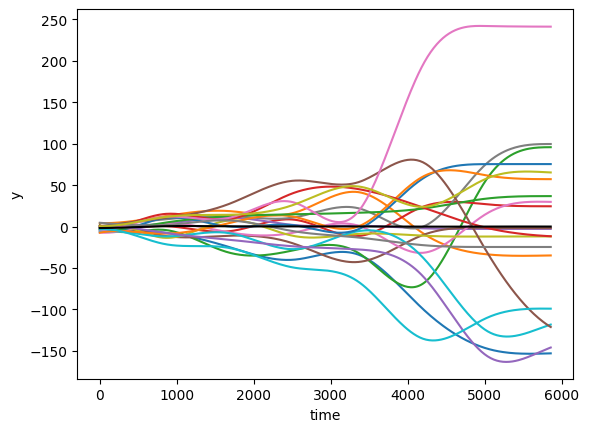

In [39]:
# Subject difference smooths - is there a subject-specific difference from the general trend?
subs = np.unique(dat["sub"])

avg_pred = None
for sub in subs:
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    new_dat = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                            "time":time_pred,
                            "sub":[sub for _ in range(len(time_pred))],
                            "x":[1 for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,_ = model7.predict([5],new_dat)
    if avg_pred is None:
        avg_pred = pred
    else:
        avg_pred += pred
    plt.plot(time_pred,pred)

plt.plot(time_pred,avg_pred/len(subs),color="black")
plt.xlabel("time")
plt.ylabel("y")
plt.show()

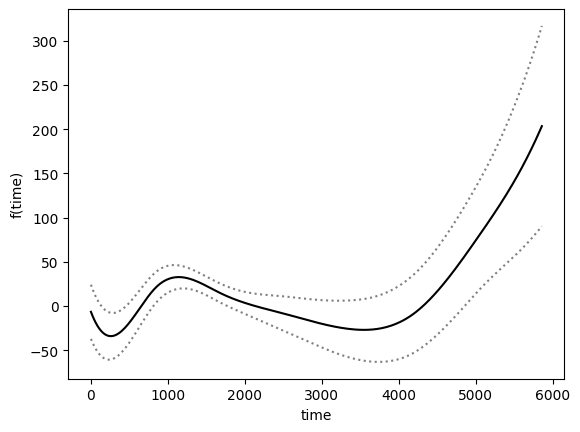

In [40]:
# Partial prediction for a single smooth
time_pred = [t for t in range(0,max(dat["time"]),20)]
x_pred = np.linspace(min(dat["x"]),max(dat["x"]),len(time_pred))
new_dat = pd.DataFrame({"time":time_pred,
                       "x":x_pred,
                       "sub":0,
                       "cond":"b"})

# Make partial prediction using just terms[1] - the smooth of time or f(time)!
pred,pred_mat,boundary = model7.predict([2],new_dat,ci=True,alpha=0.05)

plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred + boundary,color='grey', linestyle='dotted')
plt.plot(time_pred,pred - boundary,color='grey', linestyle='dotted')
plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

The model below is similar to the previous one. The non-linear random effect is built differently here, and the estimate looks different as well. This model is a bit more storage efficient so if that is a concern it might be worth considering using this parameterization.

In [41]:
formula8 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",constraint=ConstType.QR), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",constraint=ConstType.QR), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",constraint=ConstType.QR), # three-way interaction
                               f(["time"],by="sub",id=1,identifiable=False,penalty=[PenType.DIFFERENCE,PenType.IDENTITY],pen_kwargs=[{"m":1},{}],nk=10)], # Random non-linear effect of time - one smooth per level of factor sub
                        data=dat)

In [42]:
# Fit the model
model8 = GAMM(formula8,Gaussian())
model8.fit()
model8.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  68%|██████▊   | 34/50 [00:11<00:05,  3.06it/s]                

f(['time'],by=cond): a; edf: 6.876
f(['time'],by=cond): b; edf: 8.601
f(['x'],by=cond): a; edf: 1.199
f(['x'],by=cond): b; edf: 1.022
f(['time', 'x'],by=cond): a; edf: 1.007
f(['time', 'x'],by=cond): b; edf: 1.031
f(['time'],by=sub); edf: 131.004


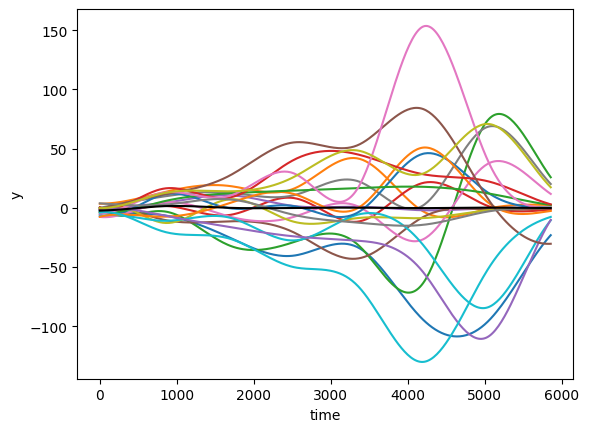

In [43]:
# Subject difference smooths - is there a subject-specific difference from the general trend?
subs = np.unique(dat["sub"])

avg_pred = None
for sub in subs:
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    new_dat = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                            "time":time_pred,
                            "sub":[sub for _ in range(len(time_pred))],
                            "x":[1 for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,_ = model8.predict([5],new_dat)
    if avg_pred is None:
        avg_pred = pred
    else:
        avg_pred += pred
    plt.plot(time_pred,pred)

plt.plot(time_pred,avg_pred/len(subs),color="black")
plt.xlabel("time")
plt.ylabel("y")
plt.show()

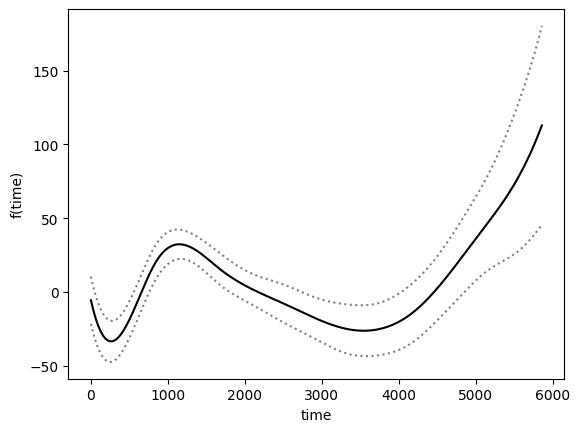

In [44]:
# Partial prediction for a single smooth
time_pred = [t for t in range(0,max(dat["time"]),20)]
x_pred = np.linspace(min(dat["x"]),max(dat["x"]),len(time_pred))
new_dat = pd.DataFrame({"time":time_pred,
                       "x":x_pred,
                       "sub":0,
                       "cond":"b"})

# Make partial prediction using just terms[1] - the smooth of time or f(time)!
pred,pred_mat,boundary = model8.predict([2],new_dat,ci=True,alpha=0.05)

plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred + boundary,color='grey', linestyle='dotted')
plt.plot(time_pred,pred - boundary,color='grey', linestyle='dotted')
plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

### Very big random effect models

mssm is particularly well suited to fit big random effect structures. The model below estimates a non-linear random effect for every individual series in the dataframe.

In [45]:
len(np.unique(dat["series"])) # 200 non-linear curves will be estimated by the random effect.

200

In [46]:
formula9 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",constraint=ConstType.QR,nk=20), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",constraint=ConstType.QR), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",constraint=ConstType.QR), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

In [47]:
# Fit the model
model9 = GAMM(formula9,Gaussian())
model9.fit()
model9.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  58%|█████▊    | 29/50 [00:42<00:30,  1.47s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.604
f(['x'],by=cond): a; edf: 1.253
f(['x'],by=cond): b; edf: 1.565
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 8.545
f(['time'],by=series); edf: 2372.125


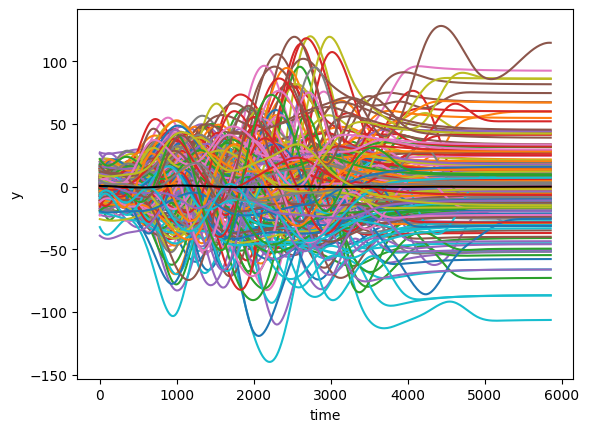

In [48]:
# Series difference smooths - is there a subject-specific difference from the general trend?
series = np.unique(dat["series"])

avg_pred = None
for ser in series:
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    new_dat = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                            "time":time_pred,
                            "series":[ser for _ in range(len(time_pred))],
                            "x":[1 for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,_ = model9.predict([5],new_dat)
    if avg_pred is None:
        avg_pred = pred
    else:
        avg_pred += pred
    plt.plot(time_pred,pred)

plt.plot(time_pred,avg_pred/len(series),color="black")
plt.xlabel("time")
plt.ylabel("y")
plt.show()

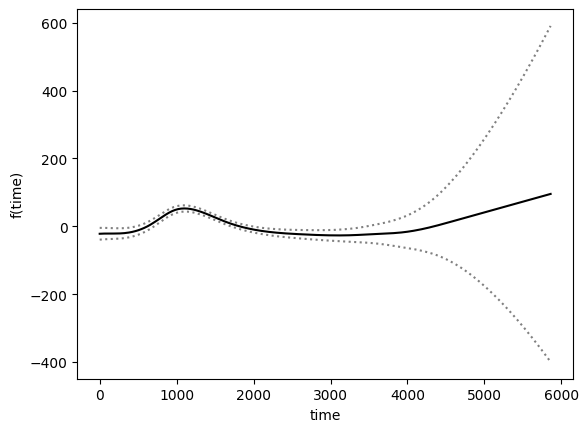

In [49]:
# Partial prediction for a single smooth
time_pred = [t for t in range(0,max(dat["time"]),20)]
x_pred = np.linspace(min(dat["x"]),max(dat["x"]),len(time_pred))
new_dat = pd.DataFrame({"time":time_pred,
                       "x":x_pred,
                       "series":0,
                       "cond":"a"})

# Make partial prediction using just terms[1] - the smooth of time or f(time)!
pred,pred_mat,boundary = model9.predict([2],new_dat,ci=True,alpha=0.05)

plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred + boundary,color='grey', linestyle='dotted')
plt.plot(time_pred,pred - boundary,color='grey', linestyle='dotted')
plt.xlabel("time")
plt.ylabel("f(time)")
plt.show()

In [50]:
# Get predictions and parameter estimates
coef, sigma = model9.get_pars() # Coef = weights for basis functions, sigma = **variance** of residuals!
pred = model9.pred # The model prediction for the entire data, here: a + f(Time)!
res = model9.res # The residuals
y = model9.formula.y_flat[model9.formula.NOT_NA_flat] # The dependent variable after NAs were removed

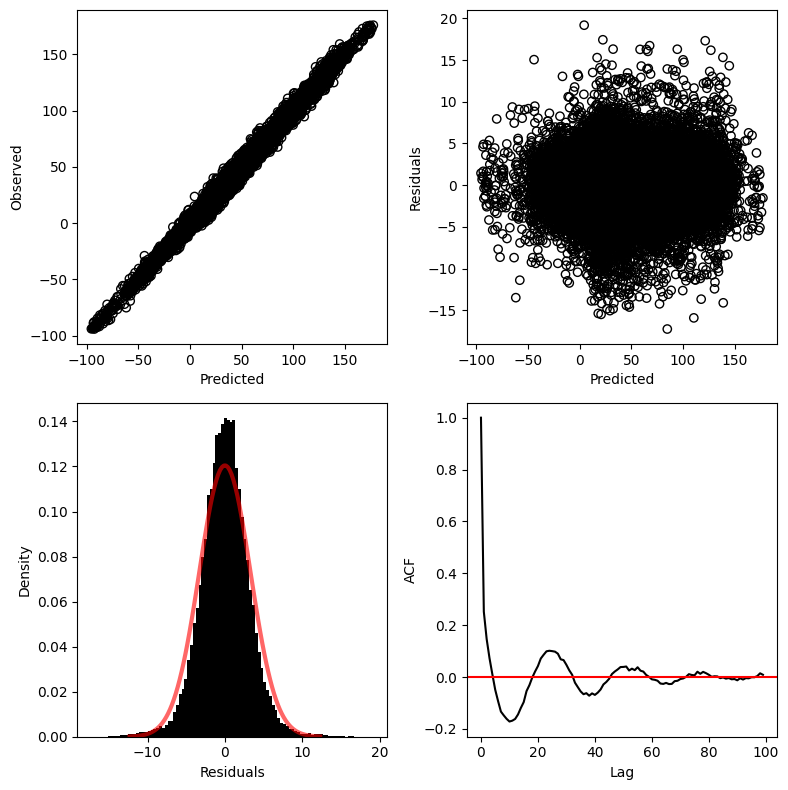

In [51]:
# Check model performance
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(pred,y,color="black",facecolor='none')
plt.xlabel("Predicted")
plt.ylabel("Observed")


plt.subplot(2,2,2)
plt.scatter(pred,res,color="black",facecolor='none')
plt.xlabel("Predicted")
plt.ylabel("Residuals")


plt.subplot(2,2,3)
plt.hist(res,bins=100,density=True,color="black")
x = np.linspace(scp.stats.norm.ppf(0.0001,scale=math.sqrt(sigma)),
                scp.stats.norm.ppf(0.9999,scale=math.sqrt(sigma)), 100)

plt.plot(x, scp.stats.norm.pdf(x,scale=math.sqrt(sigma)),
        'r-', lw=3, alpha=0.6)
plt.xlabel("Residuals")
plt.ylabel("Density")

# Auto-correlation check
lag = 100
cc = np.vstack([res[:-lag,0],*[res[l:-(lag-l),0] for l in range(1,lag)]]).T
acf = [np.corrcoef(cc[:,0],cc[:,l])[0,1] for l in range(lag)]

plt.subplot(2,2,4)
plt.plot(range(lag),acf,color="black")
plt.axhline(0,color="red")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

### Model selection

mssm supports penalty-based model selection (Marra & Wood, 2011; *Practical variable selection for generalized additive models*). In practice, that means the models can penalize entire terms out of the model (they become ~ equal to zero over their covariate(s)). To enable this, provide the ``penalize_null=True`` argument to splines for which this should be enabled (Note: to maximize efficiency, it might be a good idea to only apply this to terms that are close to the edf that could be expected from a function in the kernel of their penalty).

In [52]:
formula10 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",constraint=ConstType.QR,nk=20), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",constraint=ConstType.QR,penalize_null=True), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",constraint=ConstType.QR,penalize_null=True), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

In [53]:
# Fit the model
model10 = GAMM(formula10,Gaussian())
model10.fit()
model10.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  32%|███▏      | 16/50 [00:23<00:50,  1.49s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.605
f(['x'],by=cond): a; edf: 1.464
f(['x'],by=cond): b; edf: 1.521
f(['time', 'x'],by=cond): a; edf: 0.0 *
f(['time', 'x'],by=cond): b; edf: 7.195
f(['time'],by=series); edf: 2372.13

One term has been effectively penalized to zero and is marked with a '*'


A non-linear two-way interaction between `time` and `x` is only supported for condition `b` (since the edf for the two-way interaction for condition `a` are close to 0). This actually supports the three-way interaction. Hence, the model should not be simplified further.

We can also use an approximate GLRT (see Wood 2017) to compare the model to a nested simpler model, to check whether the reduction in complexity leads to a drastically worse fit.

In [54]:
formula11 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",constraint=ConstType.QR,nk=20), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",constraint=ConstType.QR,penalize_null=True), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],constraint=ConstType.QR,penalize_null=True), # two-way interaction between x and time
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

In [55]:
# Fit the model
model11 = GAMM(formula11,Gaussian())
model11.fit()
model11.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  32%|███▏      | 16/50 [00:20<00:44,  1.30s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.609
f(['x'],by=cond): a; edf: 1.456
f(['x'],by=cond): b; edf: 1.581
f(['time', 'x']; edf: 0.003 *
f(['time'],by=series); edf: 2372.094

One term has been effectively penalized to zero and is marked with a '*'


In [56]:
h1,p,chi,df1,df2 = GLRT_CDL(model10,model11,alpha=0.05)
print(f"Accepting alternative hypothesis that the two-way interaction between time and x actually differs between cond levels? {h1 == 1}")
print(f"Probability of observing twice the difference in log-likelihood as extreme or more extreme than {chi}\nunder the Null (interaction between time and x does not differ between cond levels): {p}")

Accepting alternative hypothesis that the two-way interaction between time and x actually differs between cond levels? [ True]
Probability of observing twice the difference in log-likelihood as extreme or more extreme than [24.68277046]
under the Null (interaction between time and x does not differ between cond levels): [0.00098146]


The GLRT also suggests that the three-way interaction contributes significantly to the model. Hence, model 10 is probably the better model than model 11. Importantly, the GLRT test is very likely biased and not necessarily conservative enough. Hence, it should generally be combined with other evidence (i.e., based on null-penalty information). P-values close to one's personal alpha level should thus be considered very carefully.

It might be more appropriate to use the GLRT only on models that have not received extra penalties on the Null-space.